## Word2Vec 구현하기(Skip-Gram)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import collections
import math
import os
import zipfile

In [3]:
import numpy as np
from six.moves import urllib
import tensorflow.compat.v1 as tf
tf.executing_eagerly()

True

# Step1: 데이터 다운로드

In [4]:
url = 'http://mattmahoney.net/dc/'

In [5]:
def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

In [6]:
filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [7]:
# zip 파일에 포함된 텍스트 파일을 읽어서 단어 리스트 생성
def read_data(filename):
    # 포함된 파일은 1개
    # zip 파일은 30mb, txt 파일은 100mb
    with zipfile.ZipFile(filename) as f:
        names = f.namelist()                # ['text8']
        contents = f.read(names[0])         # 크기 : 100,000,000바이트
        text = tf.compat.as_str(contents)   # 크기 : 100,000,000
        return text.split() 

In [8]:
vocabulary = read_data(filename)
print('Data size:', len(vocabulary))         # 갯수: 17005207

Data size: 17005207


# Step2: 사전 구축 및 출현빈도 적은 단어 UNK 토큰 대체

* UNK는 unknown 약자로 출현빈도가 낮은 단어들을 모두 대체한다. 
* 1700만개의 단어 중 빈도가 높은 50,000개 단어를 데이터셋으로 구축한다.

In [9]:
vocabulary_size = 50000

In [10]:
def build_dataset(words, n_words):
    # 출현빈도가 높은 5만개 추출
    unique = collections.Counter(words)             # 중복 단어 제거
    orders = unique.most_common(n_words - 1)        # 단어에 대한 빈도 계산, 갯수를 지정하지 않으면 전체 계산
    count = [['UNK', -1]]
    count.extend(orders)

    # 딕셔너리를 이용하여 아래와 같이 단어에 번호 부여
    # dictionary : (UNK, 0) (the, 1) (of, 2) (and, 3) (one, 4) (in, 5) (a, 6) (to, 7)
    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary)

    # 리스트를 이용하여 단어 인덱스 매핑
    data = []
    for word in words:
        if word in dictionary:          # word가 dictionary에 존재하는 경우
            index = dictionary[word]
        else:
            index = 0                   # UNK는 0번째에 위치
            count[0][1] += 1            # 갯수 : 418391
        data.append(index)

    return data, count, list(dictionary.keys())

In [11]:
# data : 단어에 대한 인덱스만으로 구성된 리스트
# count : 단어와 빈도 쌍으로 구성된 리스트
# ordered_words : 빈도에 따라 정렬된 단어 리스트
data, count, ordered_words = build_dataset(vocabulary, vocabulary_size)

In [12]:
print('Most common words (+UNK)', count[:5]) # UNK를 포함하여 출현빈도가 높은 단어 5개 출력

Most common words (+UNK) [['UNK', 418390], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]


In [13]:
del vocabulary, count               # 사용하지 않는 변수 삭제

# Step3: skip-gram 모델에 사용할 학습데이터를 위한 함수

* Stochastic Gradient Descent 알고리즘에 사용할 minibatch를 생성한다.

> 변수설명  
* data : 단어 인덱스 리스트
* batch_size : SGD 알고리즘에 적용할 데이터 갯수/ 한 번에 처리할 크기
* num_skips : context window에서 구축할 (target, context) 쌍의 갯수
* skip_window : skip-gram 모델에 사용할 윈도우 크기  
  ex) 1이라면 목표 단어(target) 양쪽에 1개 단어이므로 context window 크기는 3이 되고 (단어 target 단어)  2라면 5가 된다. (단어 단어 target 단어 단어)
* data_index : 첫 번째 context window에 들어갈 data에서의 시작 위치    

In [14]:
def generate_batch(data, batch_size, num_skips, skip_window, data_index):
    # 아래 조건이 False라면 비정상 종료
    assert batch_size % num_skips == 0              # batch_size는 num_skips의 정수 배
    assert num_skips <= 2 * skip_window             # num_skips는 skip_window의 2배 이하
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)      # batch는 1차원
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)  # labels는 2차원

    # 아래 조건이 False라면 비정상 종료
    span = 2 * skip_window + 1                      # context = skip_window + target + skip_window
    assert span > num_skips

    # deque
    # 양쪽 끝에서 빠르게 추가와 삭제를 할 수 있는 리스트류 컨테이너
    # 처음과 마지막의 양쪽 끝에서 일어나는 입출력에 대해 가장 좋은 성능을 내는 자료구조
    # maxlen 옵션이 없으면 크기 제한이 없고, 있다면 지정한 크기만큼만 사용 가능
    # maxlen을 3으로 전달하면 3개만 저장할 수 있고, 새로운 요소를 추가하면 반대쪽 요소가 자동으로 삭제됨
    # 해당 코드에서는 자동 삭제 기능 때문에 사용
    # data_index 번째부터 span 크기만큼 단어 인덱스 저장
    # 첫 번째 context 윈도우 구성
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)   # 다음 단어 인덱스로 이동

    
    # skip-gram은 타겟 단어로부터 주변의 컨텍스트 단어를 예측하는 모델이다.
    # 학습하기 전에 단어들을 (target, context) 형태로 변환해 주어야 한다.
    # 바깥 루프는 batch_size // num_skips
    # 안쪽 루프는 num_skips
    # batch_size는 num_skips로 나누어 떨어지기 때문에 정확하게 batch_size만큼 반복
    for i in range(batch_size // num_skips):

        # skip_window는 context의 가운데 위치한 단어의 인덱스
        # skip_window가 3이라면 주변에 3개의 단어씩 위치하게 되고 3+1+3은 7개로 구성된 context가 만들어진다.
        # 읽어올 데이터가 0부터 시작한다면 skip_window는 3이 되고, context의 가운데에 위치한다.
        # 값을 생성할 때, num_skips와 span 중에서 신중하게 선택해야 한다.
        # num_skips는 context로부터 구성할 단어들의 갯수이기 때문에
        # num_skips를 사용하면 context에 포함된 단어들의 모든 인덱스가 반영되지 않을 수 있다.
        # skip_window*2 == num_skips 일 때는 모든 단어를 사용하기 때문에 난수를 사용할 필요가 없다.
        # 여기서는 항상 skip_window는 1, num_skips는 2의 값을 갖는다.
        targets = list(range(span))     # 1. 0부터 span-1까지의 정수로 채운 다음
        targets.pop(skip_window)        # 2. skip_window번째 삭제
        np.random.shuffle(targets)      # 3. 난수를 사용해서 섞는다.

        # batch : target 단어만 들어가고, num_skips만큼 같은 단어가 중복된다.
        # labels : target을 제외한 단어만 들어가고, num_skips만큼 중복될 수 있다.
        start = i * num_skips
        batch[start:start+num_skips] = buffer[skip_window]

        # buffer는 numpy 데이터가 아니라서 슬라이스 연산 불가하여 반복문 사용
        for j in range(num_skips):
            labels[start+j, 0] = buffer[targets[j]]
            
        # 새로운 요소가 들어가면서 가장 먼저 들어간 데이터 삭제
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # data_index는 반복문에서 batch_size // num_skips 만큼 증가하므로
    # 해당 코드를 실행하면 최종적인 data_index는 마지막을 지난 위치를 가리키게 된다.
    # 이는 정확한 계산을 위해 원래 값으로 돌려놓는 코드이다.
    # span에 context 윈도우 전체 크기가 있으니까, span만큼 뒤로 이동한다.
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels, data_index

In [15]:
# generate_batch 함수 테스트
batch, labels, data_index = generate_batch(data, batch_size=8, num_skips=2, skip_window=1, data_index=0)
for i in range(8):
    print('{} {} -> {} {}'.format(batch[i], ordered_words[batch[i]], labels[i, 0], ordered_words[labels[i, 0]]))

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 3081 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 2 of
195 term -> 6 a


# Step 4: skip-gram 모델 구축

In [17]:
np.random.seed(1)
tf.random.set_random_seed(1)

In [18]:
batch_size = 128        
embedding_size = 128    # embedding vector 크기
skip_window = 1         # target 양쪽으로 고려할 단어 갯수
num_skips = 2           # 컨텍스트로부터 생성할 레이블 갯수

In [19]:
# sample에 대한 validation set 선택
# 가장 자주 생성되고 낮은 숫자 인덱스를 가진 단어로 추출
valid_size = 16     # 유사성을 평가할 단어 집합 크기
valid_window = 100  # 분포의 앞부분에서만 선택
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # sample에 대한 negative 샘플링 갯수

In [20]:
# 학습을 위한 input 데이터
tf.compat.v1.disable_eager_execution() 
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [22]:
# NCE loss 변수
# weights: (50000, 128)/ biases: (50000,)
truncated = tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size))
nce_weights = tf.Variable(truncated)
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [23]:
# embeddings 벡터
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [24]:
# 배치 데이터에 대해 NCE loss 평균 계산
nce_loss = tf.nn.nce_loss(weights=nce_weights,
                          biases=nce_biases,
                          labels=train_labels,
                          inputs=embed,
                          num_sampled=num_sampled,
                          num_classes=vocabulary_size)
loss = tf.reduce_mean(nce_loss)

In [25]:
# SGD optimizer
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

In [26]:
# 유사도를 계산하기 위한 모델
# minibatch 데이터(valid embeddings)와 모든 embeddins 사이의 코사인 유사도 계산
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


# Step5: skip-gram 모델 학습

In [27]:
num_steps = 100001              # 마지막 반복을 출력하기 위해 +1

In [28]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())

    average_loss, data_index = 0, 0
    for step in range(num_steps):
        batch_inputs, batch_labels, data_index = generate_batch(data, batch_size, num_skips, skip_window, data_index)

        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        # 마지막 2000번에 대한 평균 loss 표시
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print('Average loss at step {} : {}'.format(step, average_loss))
            average_loss = 0

        # 중간 결과 표시
        if step % 10000 == 0:
            # 16개의 단어로부터 vocabulary에 포함된 모든 단어까지의 거리 계산
            # 샘플 단어 1개당 50000번 계산
            # valid_dataset에 전달된 인덱스를 사용해서 유사도 계산
            sim = similarity.eval()         # (16, 50000)

            for i in range(valid_size):
                valid_word = ordered_words[valid_examples[i]]
                
                # 유사도가 높은 단어 선택
                # sim[i, :]    : valid_dataset에서 i번째 단어에 대한 유사도
                # argsort      : 배열이 오름차순으로 정렬되었을 때의 값들에 대한 순서 리스트 반환
                # -sim[i, :]   : 음수로 변환하여 정렬을 내림차순으로 정렬하여 유사도가 높은 앞부분을 추출하기 위함
                # [1:top_k + 1]: 전체 배열에서 [1:top_k + 1] 앞부분 8개만 슬라이싱
                
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]

    # final_embeddings는 normalized_embeddings 크기와 같고, 다음 단계에서 시각화하는 용도로 사용
    # 타입: ndarray, 크기: (vocabulary_size, embedding_size) = (50000, 128)
    final_embeddings = normalized_embeddings.eval()

Average loss at step 0 : 286.19512939453125
Average loss at step 2000 : 114.01767312002183
Average loss at step 4000 : 53.03419408273697
Average loss at step 6000 : 32.88585957074165
Average loss at step 8000 : 23.230577528715134
Average loss at step 10000 : 17.859516840100287
Average loss at step 12000 : 14.105349306225778
Average loss at step 14000 : 11.506058521866798
Average loss at step 16000 : 9.913985414981841
Average loss at step 18000 : 8.450078211188316
Average loss at step 20000 : 8.108143291592597
Average loss at step 22000 : 7.081930048465729
Average loss at step 24000 : 6.854857223510742
Average loss at step 26000 : 6.743554379105568
Average loss at step 28000 : 6.36723572230339
Average loss at step 30000 : 5.937094979643822
Average loss at step 32000 : 5.993425595283508
Average loss at step 34000 : 5.700586915373802
Average loss at step 36000 : 5.76016186594963
Average loss at step 38000 : 5.467110004067421
Average loss at step 40000 : 5.265553604245186
Average loss at s

## Step6: embeddings 시각화

In [29]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))        # in inches

    # 해당 좌표에 점을 표시하고, 오른쪽/하단 정렬로 단어를 표시한다.
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i]

        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

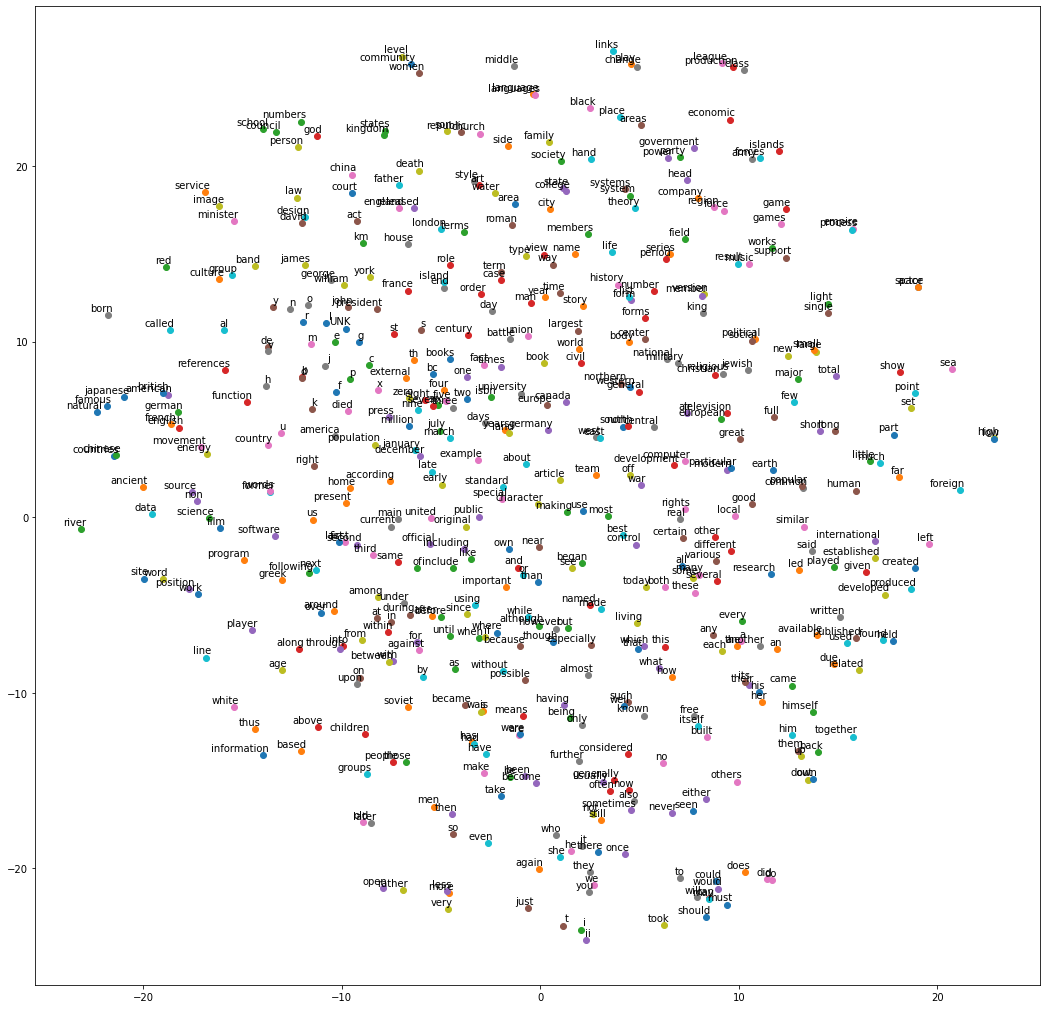

In [30]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    # perplexity   : 가장 가까운 이웃 갯수
    # n_components : 차원, low_dim_embs와 차원 같아야함
    # init         : embedding 초기화 방법
    # n_iter       : 최적화에 사용할 반복 횟수
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

    # plot 갯수, 50000개의 embeddings로부터 앞쪽 일부만 사용
    # low_dim_embs에는 변환된 좌표 x, y가 들어있음
    plot_only = 500 # plot 갯수
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only])     # (500, 2)
    labels = ordered_words[:plot_only]                              

    plot_with_labels(low_dim_embs, labels)
    
except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

출처 : https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
